In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("fer2013/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df.shape

(35887, 3)

## Plotting Shapes

<AxesSubplot:xlabel='emotion', ylabel='count'>

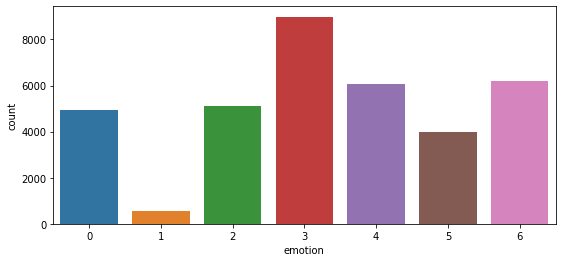

In [6]:
plt.figure(figsize = (9,4))
sns.countplot(x='emotion' , data = df)

In [7]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

Here we have
#### 0 : Angry
#### 1 : Disgust
#### 2 : Fear
#### 3 : Happy
#### 4 : Sad
#### 5 : Surprise
#### 6 : Neutral

<AxesSubplot:xlabel='Usage', ylabel='count'>

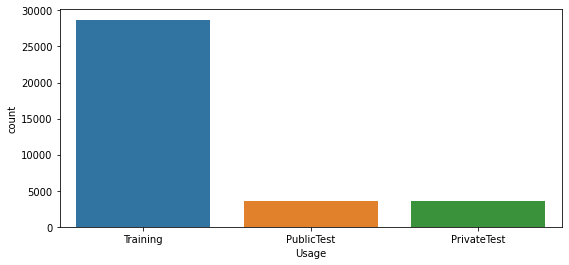

In [8]:
plt.figure(figsize=(9,4))
sns.countplot(x = 'Usage' , data=df)

## Preprocess

In [9]:
import cv2
image_size = (48,48)

In [10]:
#Convert column element to list for each row
pixels = df['pixels'].tolist()

w , h = 48 , 48
faces = []

for pixel_seq in pixels:
    face = [int(pixel) for pixel in pixel_seq.split(' ')]
    
    face = np.asarray(face).reshape(w,h)
    
    face = cv2.resize(face.astype('uint8') , image_size)
    
    faces.append(face.astype('float32'))
    
faces = np.asarray(faces)
faces = np.expand_dims(faces , -1)

emotions = pd.get_dummies(df['emotion']).to_numpy()

In [11]:
print(faces[2])
print(emotions[2])

[[[231.]
  [212.]
  [156.]
  ...
  [ 44.]
  [ 27.]
  [ 16.]]

 [[229.]
  [175.]
  [148.]
  ...
  [ 27.]
  [ 35.]
  [ 27.]]

 [[214.]
  [156.]
  [157.]
  ...
  [ 28.]
  [ 22.]
  [ 28.]]

 ...

 [[241.]
  [245.]
  [250.]
  ...
  [ 57.]
  [101.]
  [146.]]

 [[246.]
  [250.]
  [252.]
  ...
  [ 78.]
  [105.]
  [162.]]

 [[250.]
  [251.]
  [250.]
  ...
  [ 88.]
  [110.]
  [152.]]]
[0 0 1 0 0 0 0]


In [12]:
faces.shape

(35887, 48, 48, 1)

In [13]:
emotions.shape

(35887, 7)

## SPliiting Dataset

### Scalling data pixels b/w -1 to 1

In [14]:
x = faces.astype('float32')
x = x / 255.0

x = x - 0.5

x = x * 2.0

In [15]:
type(x)

numpy.ndarray

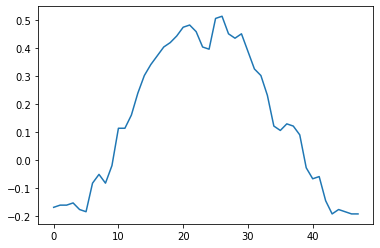

In [16]:
plt.plot(x[15,8])
plt.show()

In [17]:
x.min()

-1.0

In [18]:
x.max()

1.0

### Splitting Train and validate

In [19]:
num_samp , num_classes = emotions.shape

In [20]:
num_samp = len(x)
num_train_samp = int((1.0 - 0.2)*num_samp)

train_x , train_y = x[:num_train_samp] , emotions[:num_train_samp]

val_x , val_y = x[num_train_samp:] , emotions[num_train_samp:]

train_data = (train_x , train_y)
val_data = (val_x , val_y)

In [21]:
print("Training size" , train_x.shape)
print("Training labels size" , train_y.shape)
print("Validation pixels size" , val_x.shape)
print("Validation label size" , val_y.shape)

Training size (28709, 48, 48, 1)
Training labels size (28709, 7)
Validation pixels size (7178, 48, 48, 1)
Validation label size (7178, 7)


## Defining Model

In [22]:
from tensorflow.keras.layers import Activation , Convolution2D , Dropout , Conv2D
from tensorflow.keras.layers import AveragePooling2D , BatchNormalization , MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Flatten , Input , SeparableConv2D
from tensorflow.keras.regularizers import l2

In [23]:
input_shape = (48 , 48  ,1)
num_classes = 7

In [24]:
model = Sequential()

model.add(Convolution2D(filters = 16 , kernel_size = (7,7) , padding = 'same' , name = 'image_array' , input_shape = input_shape))
model.add(BatchNormalization())
model.add(Convolution2D(filters = 16 , kernel_size = (7,7) , padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size = (2,2) , padding = 'same'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())

model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
model.add(GlobalAveragePooling2D())

model.add(Activation('softmax',name='predictions'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_array (Conv2D)         (None, 48, 48, 16)        800       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 16)        12560     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 48, 48, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 24, 24, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 16)        0

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(
                featurewise_center = False,
                featurewise_std_normalization = False,
                rotation_range = 10,
                width_shift_range = 0.1,
                height_shift_range = 0.1,
                zoom_range = 0.1,
                horizontal_flip = True
           )

In [27]:
from tensorflow.keras.callbacks import CSVLogger , ModelCheckpoint , EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [28]:
model.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_array (Conv2D)         (None, 48, 48, 16)        800       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 16)        12560     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 48, 48, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 24, 24, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 16)        0

In [29]:
batch_size = 32 
num_epochs = 200
verbose = 1 
num_classes = 7 
patience = 50

In [32]:
dataset = ['fer2013']
num_epochs = 30
base_path = '/'

for dataset_name in dataset:
    print('Training dataset : ' , dataset_name)
    
    log_file_path = dataset_name + '_emotion_training.log'
    
    csv_logger = CSVLogger(log_file_path , append=False)
    early_stop = EarlyStopping('val_loss' , patience= patience)
    reduce_lr = ReduceLROnPlateau('val_loss' , factor = 0.1 , patience=int(patience/4) , verbose=1)
    
    trained_models_path = base_path + dataset_name + 'simple_cnn'
    model_names = trained_models_path + '.{epoch:02d} - {val_loss:.2f}.hdf5'
    
    model_checkpoint = ModelCheckpoint(model_names , 'val_loss' , verbose=1 , save_best_only=True)
    
    my_callbacks = [model_checkpoint , csv_logger , early_stop , reduce_lr]
    
    train_faces , train_emotions = train_data
    history = model.fit_generator(data_gen.flow(train_faces , train_emotions , batch_size) , epochs = num_epochs , verbose=1 , callbacks=my_callbacks , validation_data=val_data)
    

Training dataset :  fer2013
Epoch 1/30
898/898 [==============================] - ETA: 0s - loss: 1.6286 - accuracy: 0.3543
Epoch 00001: val_loss improved from inf to 1.55001, saving model to /fer2013simple_cnn.01 - 1.55.hdf5
898/898 [==============================] - 287s 319ms/step - loss: 1.6286 - accuracy: 0.3543 - val_loss: 1.5500 - val_accuracy: 0.3904
Epoch 2/30
898/898 [==============================] - ETA: 0s - loss: 1.5749 - accuracy: 0.3834
Epoch 00002: val_loss improved from 1.55001 to 1.45437, saving model to /fer2013simple_cnn.02 - 1.45.hdf5
898/898 [==============================] - 277s 308ms/step - loss: 1.5749 - accuracy: 0.3834 - val_loss: 1.4544 - val_accuracy: 0.4402
Epoch 3/30
898/898 [==============================] - ETA: 0s - loss: 1.5276 - accuracy: 0.4006
Epoch 00003: val_loss improved from 1.45437 to 1.41056, saving model to /fer2013simple_cnn.03 - 1.41.hdf5
898/898 [==============================] - 277s 309ms/step - loss: 1.5276 - accuracy: 0.4006 - val_l

Epoch 27/30
898/898 [==============================] - ETA: 0s - loss: 1.2785 - accuracy: 0.5164
Epoch 00027: val_loss did not improve from 1.13856
898/898 [==============================] - 314s 350ms/step - loss: 1.2785 - accuracy: 0.5164 - val_loss: 1.2239 - val_accuracy: 0.5357
Epoch 28/30
898/898 [==============================] - ETA: 0s - loss: 1.2748 - accuracy: 0.5125
Epoch 00028: val_loss did not improve from 1.13856
898/898 [==============================] - 301s 335ms/step - loss: 1.2748 - accuracy: 0.5125 - val_loss: 1.1395 - val_accuracy: 0.5624
Epoch 29/30
898/898 [==============================] - ETA: 0s - loss: 1.2736 - accuracy: 0.5179
Epoch 00029: val_loss did not improve from 1.13856
898/898 [==============================] - 304s 338ms/step - loss: 1.2736 - accuracy: 0.5179 - val_loss: 1.1519 - val_accuracy: 0.5521
Epoch 30/30
898/898 [==============================] - ETA: 0s - loss: 1.2720 - accuracy: 0.5161
Epoch 00030: val_loss improved from 1.13856 to 1.13726

In [33]:
score = model.evaluate(val_x , val_y , verbose=1)
print('Test Loss : ' , score[0])
print('Test Accuracy : ' , score[1]*100 , "%")

225/225 [==============================] - 9s 41ms/step - loss: 1.1373 - accuracy: 0.5605
Test Loss :  1.1372560262680054
Test Accuracy :  56.04625344276428 %


In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [35]:
print(history_dict["accuracy"])

[0.35427916049957275, 0.3834337592124939, 0.40064090490341187, 0.4166637659072876, 0.4324776232242584, 0.44550490379333496, 0.4553624391555786, 0.4619109034538269, 0.46689191460609436, 0.47943153977394104, 0.47998884320259094, 0.4861193299293518, 0.4864676594734192, 0.4893239140510559, 0.4923194944858551, 0.49611619114875793, 0.49914661049842834, 0.5029433369636536, 0.49841514229774475, 0.508272647857666, 0.5044062733650208, 0.5111289024353027, 0.5106064081192017, 0.5135323405265808, 0.5154829621315002, 0.5156571269035339, 0.5164234042167664, 0.5125222206115723, 0.5179212093353271, 0.516075074672699]


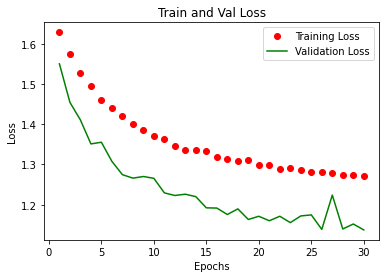

In [36]:
train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(history_dict['accuracy']) + 1)

plt.plot(epochs , train_loss_values , 'ro' , label="Training Loss")
plt.plot(epochs , val_loss_values , 'g-' , label="Validation Loss")
plt.title('Train and Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

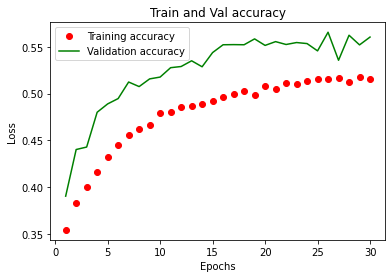

In [37]:
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, train_acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'g-', label='Validation accuracy')
plt.title('Train and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
emotion_dict = {0: "Neutral", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Sad", 5: "Surprised", 6: "Neutral"}
emojis = { 0:"\U0001f620",1:"\U0001f922" ,2:"\U0001f628" ,3:"\U0001f60A" , 4:"\U0001f625" ,5:"\U0001f632",6:"\U0001f610" }

In [39]:
print(emojis.values() , sep = " ")

dict_values(['😠', '🤢', '😨', '😊', '😥', '😲', '😐'])


In [ ]:
%matplotlib inline

In [48]:
import cv2

def predict(path):
    facecasc = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    imagePath = path
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=10)
    print("No of faces : ",len(faces))
    i = 1
    for (x, y, w, h) in faces:
        i=i+1
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]                      #croping
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)

        maxindex = int(np.argmax(prediction))
        print("person ",i," : ",emotion_dict[maxindex], "-->",emojis[maxindex])
        cv2.putText(image, emotion_dict[maxindex], (x+10, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)  
                                              #if text is not apeared , change coordinates. it may work
  
    plt.imshow(image)
    plt.show()

In [51]:

predict('trial.jpg')

No of faces :  1
person  2  :  Fearful --> 😨
